In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# for url hitting
import requests 
# for parsing
from bs4 import BeautifulSoup 

def info_extract(urls):
    news_data = []
    
    for url in urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', attrs = {'itemprop': 'headline'}).string, 
                          'news_article': article.find('div', attrs = {'itemprop': 'articleBody'}).string, 
                          'news_category': news_category} 
                         
                         for headline, article in zip(soup.find_all('div', class_ = ['news-card-title news-right-box']), 
                                                      soup.find_all('div', class_ = ['news-card-content news-right-box']))
                        ]
        news_data.extend(news_articles)
        
    df = pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    
    return df

In [3]:
urls = ['https://inshorts.com/en/read/technology',
        'https://inshorts.com/en/read/sports',
        'https://inshorts.com/en/read/world']

news_df = info_extract(urls)
news_df.head()

,news_headline,news_article,news_category
0,Jio GigaFiber to launch on Sept 5; plans to st...,Mukesh Ambani has announced that Jio GigaFiber...,technology
1,Jio to set up data centres across India in par...,At the annual general meeting of Reliance Indu...,technology
2,Researchers demo way to fool Apple's Face ID f...,Tencent Security researchers at the 2019 Black...,technology
3,Google marks ISRO Founder's 100th birth annive...,Google on Monday celebrated the 100th birth an...,technology
4,Foxconn uses illegal child labour for Amazon d...,A report by The Guardian accused Taiwanese ele...,technology


In [4]:
# removing HTML tags

def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text()
    return stripped_text

print(strip_html_tags('<html>This is a stripped text</html>'))

This is a stripped text


In [5]:
# remove accented characters

# for converting accented characters to ASCII characters
import unicodedata 

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

print(remove_accented_chars('Sómě Áccěntěd těxt'))

Some Accented text


In [6]:
# expanding contractions

import re
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping = CONTRACTION_MAP):
    # compiling all match patterns
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags = re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        # converting re.match object to String
        contracted_text = contraction.group(0)
        # assigning expanded text whether contracted text is upper or lower case
        expanded_text = contraction_mapping.get(contracted_text) if contraction_mapping.get(contracted_text) else contraction_mapping.get(contracted_text.lower())
        # adding first character of contracted text so that if upper case, use upper case in expanded text
        expanded_text = contracted_text[0] + expanded_text[1:]
        return expanded_text
    
    # substituting match pattern with expanded match in text String
    full_text = contractions_pattern.sub(expand_match, text)
    full_text = re.sub("'", "", full_text)
    
    return full_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [7]:
# remove special characters

def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!")

'Well this was fun What do you think '

In [8]:
# stemming

import nltk
from nltk.stem.porter import *

def stemming(text):
    stemmer = PorterStemmer()
    stemmed_text = ' '.join([stemmer.stem(word) for word in text.split()])
    return stemmed_text

stemming('My system keeps crashing his crashed yesterday, ours crashes daily')

'My system keep crash hi crash yesterday, our crash daili'

In [9]:
# lemmatization using spacy

import spacy

nlp = spacy.load('en', parse=True, tag=True, entity=True)

def lemmatization(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatization('My system keeps crashing his crashed yesterday, ours crashes daily')

'My system keep crash his crash yesterday , ours crash daily'

In [10]:
# removing stop words

# faster than word tokenizer
from nltk.tokenize.toktok import ToktokTokenizer 

tokenizer = ToktokTokenizer()
# nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    filtered_text = ' '.join([token for token in tokens if token.lower() not in stopword_list])
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [11]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    
    for doc in corpus:
        if html_stripping:
            doc = strip_html_tags(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc = doc.lower()
        # remove extra new lines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        if text_lemmatization:
            doc = lemmatization(doc)
        if special_char_removal:
            doc = remove_special_characters(doc)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        if stopword_removal:
            doc = remove_stopwords(doc)
        
        normalized_corpus.append(doc)
    
    return normalized_corpus

In [12]:
news_df['full_text'] = news_df['news_headline'] + ". " + news_df['news_article']
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': "Jio to set up data centres across India in partnership with Microsoft. At the annual general meeting of Reliance Industries Ltd on Monday, Mukesh Ambani said Jio will set up a network of large world-class data centres across India in partnership with Microsoft. Ambani said Microsoft will bring its Azure cloud platform into Jio's data centres. He added that Jio will provide connectivity and cloud service to budding startups absolutely free.",
 'clean_text': 'jio set datum centre across india partnership microsoft annual general meeting reliance industry ltd monday mukesh ambani say jio set network large world class datum centre across india partnership microsoft ambani say microsoft bring azure cloud platform jios datum centre add jio provide connectivity cloud service budding startup absolutely free'}

In [13]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Jio,NNP,PROPN
1,to,TO,PART
2,set,VB,VERB
3,up,RP,PART
4,data,NNS,NOUN
5,centres,NNS,NOUN
6,across,IN,ADP
7,India,NNP,PROPN
8,in,IN,ADP
9,partnership,NN,NOUN


In [14]:
# POS tagging with nltk

# nltk.download('averaged_perceptron_tagger')
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Jio,NNP
1,to,TO
2,set,VB
3,up,RP
4,data,NNS
5,centres,NNS
6,across,IN
7,India,NNP
8,in,IN
9,partnership,NN


In [15]:
# extracting training and test data from conll2000 corpus having chunk sentences (sentences with chunk annotations)

# nltk.download('conll2000')
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [16]:
# tree2conlltags, to get chunk tags from chunk sentences

from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [17]:
# extracts POS tags and chunk tags from chunk sentences
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


# creating backoff taggers
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [18]:
# train a BigramTagger with a UnigramTagger as the backoff tagger and evaluate the model performance on the test_data

from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    
    def __init__(self, train_data, tagger_classes = [UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tag_chunks(train_data)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)
    
    # called by evaluate function for parsing the tree
    def parse(self, tagged_sentence):
        if not tagged_sentence:
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for pos_tag, chunk_tag in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag) in zip(tagged_sentence, chunk_tags)]
        # conlltags2tree to generate a parse tree from these token triples(word, chunk tags, chunk annotations)
        return conlltags2tree(wpc_tags)
    
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [19]:
# model can now chunk sentences
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Jio/NNP)
  (VP to/TO set/VB)
  up/RP
  (NP data/NNS centres/NNS)
  (PP across/IN)
  (NP India/NNP)
  (PP in/IN)
  (NP partnership/NN)
  (PP with/IN)
  (NP Microsoft/NNP))


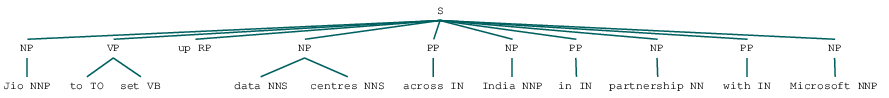

In [20]:
import os
from IPython.display import display

os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.09\\bin\\"

display(chunk_tree)

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  if __name__ == '__main__':


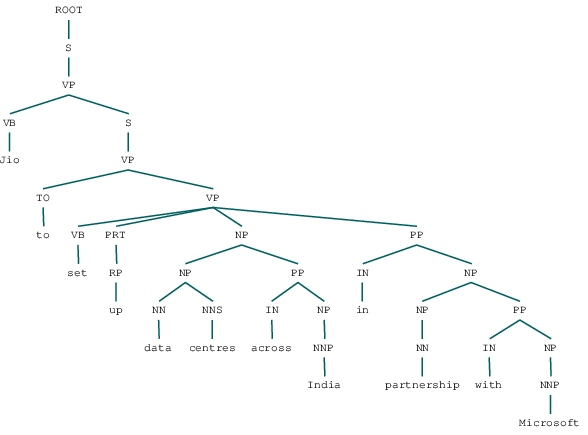

In [21]:
# constituency parsing

java_path = r'C:\Program Files\Java\jre1.8.0_152\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='C:/Users/Administrator/Desktop/Inshorts Sentiment Analysis/stanford-parser-full-2018-10-17/stanford-parser.jar',
                     path_to_models_jar='C:/Users/Administrator/Desktop/Inshorts Sentiment Analysis/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
display(result[0])

In [22]:
# dependency parsing

dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, w_type=token.dep_,
                                    left=[t.orth_ for t in token.lefts],
                                  right=[t.orth_ for t in token.rights]))

[]<---Jio[ROOT]--->['set']
--------
[]<---to[aux]--->[]
--------
['to']<---set[relcl]--->['up', 'centres', 'across', 'in']
--------
[]<---up[prt]--->[]
--------
[]<---data[compound]--->[]
--------
['data']<---centres[dobj]--->[]
--------
[]<---across[prep]--->['India']
--------
[]<---India[pobj]--->[]
--------
[]<---in[prep]--->['partnership']
--------
[]<---partnership[pobj]--->['with']
--------
[]<---with[prep]--->['Microsoft']
--------
[]<---Microsoft[pobj]--->[]
--------


In [23]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  


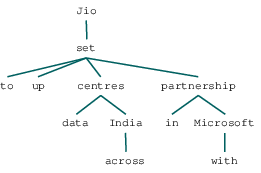

In [24]:
# another way to do dependency parsing

from nltk.parse.stanford import StanfordDependencyParser

sdp = StanfordDependencyParser(path_to_jar='C:/Users/Administrator/Desktop/Inshorts Sentiment Analysis/stanford-parser-full-2018-10-17/stanford-parser.jar',
                               path_to_models_jar='C:/Users/Administrator/Desktop/Inshorts Sentiment Analysis/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')    

result = list(sdp.raw_parse(sentence))  

dep_tree = [parse.tree() for parse in result][0]
display(dep_tree)


In [25]:
# named entity recognition

sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(India, 'GPE'), (Microsoft, 'ORG'), (annual, 'DATE'), (Reliance, 'ORG'), (Industries, 'ORG'), (Ltd, 'ORG'), (Monday, 'DATE'), (Mukesh, 'PERSON'), (Ambani, 'PERSON'), (Jio, 'PERSON'), (India, 'GPE'), (Microsoft, 'ORG'), (Ambani, 'PERSON'), (Microsoft, 'ORG'), (Azure, 'PRODUCT'), (Jio, 'PERSON'), (Jio, 'PERSON')]


In [26]:
# getting all NER

named_entities = []

for sentence in corpus:
    temp_entity_name = ''
    temp_entity = None
    sentence = nlp(sentence)
    
    for word in sentence:
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, word.text]).strip()
            temp_entity = (temp_entity_name, tag)
        else:
            if temp_entity:
                named_entities.append(temp_entity)
                temp_entity_name = ''
                temp_entity = None

entity_frame = pd.DataFrame(named_entities, columns = ['Entity Name', 'Entity Type'])

In [27]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,China,UK,first,Google,Apple,British,Israeli,ODI,Hong Kong,Microsoft,Kohli,Virat Kohli,third
Entity Type,GPE,GPE,GPE,GPE,ORDINAL,ORG,ORG,NORP,NORP,ORG,GPE,ORG,PERSON,PERSON,ORDINAL
Frequency,18,14,12,12,9,8,6,6,5,5,5,5,5,5,4


In [28]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                .size()
                .sort_values(ascending=False)
                .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,CARDINAL,DATE,NORP,ORDINAL,LOC,FAC,PRODUCT,TIME,EVENT,QUANTITY,WORK_OF_ART,PERCENT
Frequency,172,160,120,80,62,46,27,11,6,5,4,4,4,4,2


In [29]:
# check for common mistakes by spaCy
entity_frame.loc[entity_frame['Entity Type'] == "PERSON"].groupby(by=['Entity Name']).size().sort_values(ascending=False).reset_index().rename(columns={0 : 'Frequency'}).T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,Kohli,Virat Kohli,Jio,Jio GigaFiber,Yang,Instagrams Direct,Boris Johnson,Brian Lara,Gautam Gambhir,Google Maps,Eid al - Adha,Fakhar Zaman,Mahavir,Jerusalems al - Aqsa,Kim Jong - un
Frequency,5,5,4,4,3,3,3,2,2,2,2,2,2,2,2


In [30]:
# Afinn Lexicon

from afinn import Afinn

af = Afinn()
sentiment_scores = [af.score(news) for news in corpus]
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores]

df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                            
                        count  mean       std   min   25%  50%  75%   max
news_category                                                            
sports                   25.0  3.24  5.569859  -8.0   0.0  3.0  6.0  16.0
technology               25.0 -0.48  6.158463 -13.0  -4.0  0.0  2.0  13.0
world                    25.0 -5.00  7.382412 -22.0 -10.0 -5.0  0.0   9.0

In [31]:
# checking if the sentiment score of world is right
world_sentiment = list(df[df['news_category'] == "world"]['sentiment_score'])
world_news = list(news_df[news_df['news_category'] == "world"]['news_headline'])
world_df = pd.DataFrame([world_news, world_sentiment]).T
world_df.columns = ['news', 'score']
world_df = world_df.sort_values(['score'], ascending=True)
world_df.head(10)

,news,score
0,US millionaire accused of sex trafficking mino...,-22
22,Israeli forces kill 4 Palestinian terrorists o...,-17
19,Russia nuclear agency admits role in rocket ex...,-15
4,Do not advertise 'illegal' events: Russia to G...,-13
23,Fuel tanker explosion kills at least 60 in Tan...,-13
13,At least 28 killed as Typhoon Lekima hits China,-10
7,"Landslide in Myanmar kills 32, several feared ...",-10
18,"No inter-Korean talks unless S Korea, US end m...",-7
17,HK airport authority cancels all flights for M...,-7
12,UK PM Boris Johnson backs police's stop-and-se...,-7


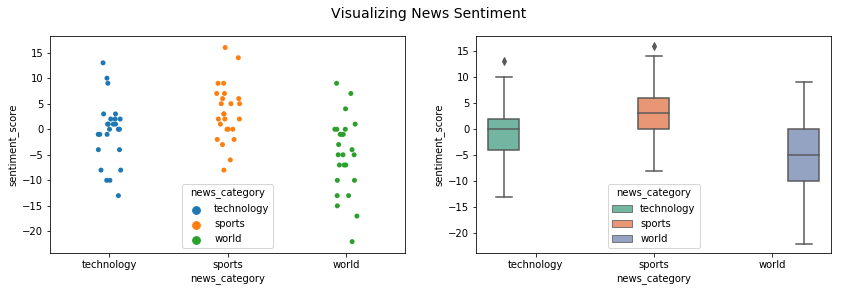

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


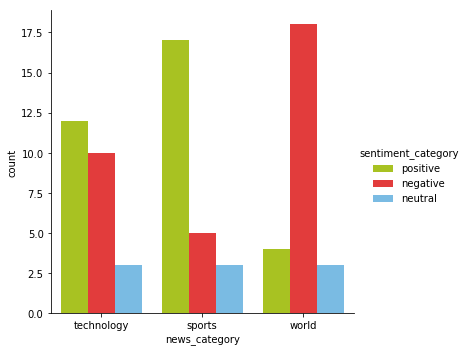

In [33]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [34]:
# TextBlob Lexicon

from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores_tb]

df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
sports                   25.0  0.18772  0.229664 -0.229  0.035  0.144  0.233   
technology               25.0  0.02828  0.221599 -0.475 -0.027  0.020  0.118   
world                    25.0  0.01880  0.166144 -0.275 -0.092  0.020  0.050   

                      
                 max  
news_category         
sports         0.800  
technology     0.552  
world          0.333

In [35]:
# comparing Affin and TextBlob treating Affin as actual and TextBlob as predicted

from sklearn import metrics

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels)) 
    print(cm_frame) 

display_confusion_matrix(true_labels=sentiment_category, predicted_labels=sentiment_category_tb, classes=['negative', 'neutral', 'positive'])

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  app.launch_new_instance()


                 Predicted:                 
                   negative neutral positive
Actual: negative         15       3       15
        neutral           0       1        8
        positive          2       4       27
